In [1]:
#!/usr/bin/env python3
"""
Bayesian per-neuron hypothesis test of sensitivity to PC1.

Pipeline:
  - Load neural data (neurons x 5900), reshape to (neurons x 118 x 50), average repeats
  - Load ViT embeddings, softmax -> CLR -> PCA (>=90% variance)
  - Take PC1 scores (length 118)
  - For each neuron j:
      * Standardize y_j across images (z-score)
      * Fit conjugate Bayesian linear model: y = a + b * x + e
        Prior: theta=[a,b] ~ N(0, (sigma^2) * Λ0^{-1}),  sigma^2 ~ InvGamma(a0,b0)
        (equivalently b ~ N(0, s_beta^2) in ridge form)
      * Closed-form posterior for b is Student-t with df=2*a_n, loc=mean_b, scale=s_b
      * Report mean_b, 95% CI, P(b>0), P(|b|>tau)
  - Save CSV
"""

import os, pickle
import numpy as np
import pandas as pd
from scipy.special import softmax
from skbio.stats.composition import clr
from sklearn.decomposition import PCA
from scipy.stats import t as student_t
from scipy.stats import pearsonr

# -------------------------
# Config
# -------------------------
VIT_PATH   = '/home/maria/Documents/HuggingMouseData/MouseViTEmbeddings/google_vit-base-patch16-224_embeddings_logits.pkl'
NEURAL_PATH= '/home/maria/LuckyMouse/pixel_transformer_neuro/data/processed/hybrid_neural_responses.npy'
N_IMAGES   = 118
REPEATS    = 50
TAU        = 0.10   # threshold for |beta| > tau in standardized-units
# Weakly-informative priors (after standardizing x,y):
s_alpha2   = 1e6    # prior var for intercept
s_beta2    = 1.0    # prior var for slope (ridge ~1 SD)
a0         = 1e-2   # InvGamma shape
b0         = 1e-2   # InvGamma scale

# -------------------------
# Load data
# -------------------------
dat = np.load(NEURAL_PATH)  # (n_neurons, 5900)
n_neurons, n_trials = dat.shape
assert n_trials == N_IMAGES * REPEATS, f"Expected {N_IMAGES*REPEATS}, got {n_trials}"
dat = dat.reshape(n_neurons, N_IMAGES, REPEATS)
firing_mean = dat.mean(axis=2)  # (n_neurons, 118)

with open(VIT_PATH, 'rb') as f:
    vit_arr = pickle.load(f)['natural_scenes']  # (118, 1000)
embeddings = np.asarray(vit_arr)
assert embeddings.shape[0] == N_IMAGES

# -------------------------
# ViT -> softmax -> CLR -> PCA (>=90% var)
# -------------------------
X = softmax(embeddings, axis=1)
X_clr = clr(X + 1e-12)

pca_full = PCA().fit(X_clr)
cumvar = np.cumsum(pca_full.explained_variance_ratio_)
K = int(np.searchsorted(cumvar, 0.90) + 1)
pca = PCA(n_components=K, random_state=0)
U = pca.fit_transform(X_clr)     # (118, K)
pc1 = U[:, 0]                    # (118,)

# Standardize predictor (helps prior scale)
x = (pc1 - pc1.mean()) / (pc1.std(ddof=1) + 1e-12)

# -------------------------
# Conjugate Bayesian linear regression utils
# Model: y ~ N(X theta, sigma^2 I)
# Prior: theta | sigma^2 ~ N(theta0, sigma^2 * Λ0^{-1}),
#        sigma^2 ~ InvGamma(a0, b0)
# Posterior:
#   Λn = Λ0 + X^T X
#   theta_n = Λn^{-1} (Λ0 theta0 + X^T y)
#   a_n = a0 + n/2
#   b_n = b0 + 0.5( y^T y + theta0^T Λ0 theta0 - theta_n^T Λn theta_n )
# Marginal for any component of theta is Student-t with:
#   df = 2*a_n
#   loc = component of theta_n
#   scale = sqrt( b_n / a_n * [Λn^{-1}]_jj )
# -------------------------
def bayes_linreg_posterior_for_beta(y, x, s_alpha2=1e6, s_beta2=1.0, a0=1e-2, b0=1e-2):
    """
    y: (n,) standardized
    x: (n,) standardized
    Returns posterior (mean_b, lo95, hi95, p_gt0, p_abs_gt_tau)
    """
    n = y.size
    X = np.column_stack([np.ones(n), x])            # design (n x 2)
    # Prior precision Λ0:
    # prior covariance diag([s_alpha2, s_beta2]) => precision diag([1/s_alpha2, 1/s_beta2])
    L0 = np.diag([1.0/s_alpha2, 1.0/s_beta2])
    theta0 = np.zeros(2)

    XtX = X.T @ X
    Xty = X.T @ y

    Ln = L0 + XtX
    Ln_inv = np.linalg.inv(Ln)
    theta_n = Ln_inv @ (L0 @ theta0 + Xty)

    a_n = a0 + n/2.0
    # yTy term:
    yTy = float(y @ y)
    quad0 = float(theta0.T @ L0 @ theta0)  # zero here
    quadn = float(theta_n.T @ Ln @ theta_n)
    b_n = b0 + 0.5 * (yTy + quad0 - quadn)

    # Posterior for beta = theta[1]:
    df = 2.0 * a_n
    loc = float(theta_n[1])
    var_comp = Ln_inv[1,1]
    scale = np.sqrt(b_n / a_n * var_comp)  # Student-t scale

    # 95% credible interval:
    lo = student_t.ppf(0.025, df, loc=loc, scale=scale)
    hi = student_t.ppf(0.975, df, loc=loc, scale=scale)

    # Posterior probabilities:
    p_gt0 = 1.0 - student_t.cdf(0.0, df, loc=loc, scale=scale)
    # P(|beta| > TAU):
    p_abs_gt_tau = 1.0 - (student_t.cdf(TAU, df, loc=loc, scale=scale)
                          - student_t.cdf(-TAU, df, loc=loc, scale=scale))

    return loc, lo, hi, p_gt0, p_abs_gt_tau

# -------------------------
# Run per neuron
# -------------------------
rows = []
for j in range(n_neurons):
    y_raw = firing_mean[j, :]
    # Standardize y (z-score) to put β in standardized units
    y_mean = y_raw.mean()
    y_std  = y_raw.std(ddof=1)
    if not np.isfinite(y_std) or y_std < 1e-12:
        rows.append((j, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan))
        continue
    y = (y_raw - y_mean) / (y_std + 1e-12)

    # Pearson r for reference
    r = np.corrcoef(x, y)[0,1]

    mean_b, lo95, hi95, p_gt0, p_abs_gt_tau = bayes_linreg_posterior_for_beta(
        y, x, s_alpha2=s_alpha2, s_beta2=s_beta2, a0=a0, b0=b0
    )

    rows.append((j, r, mean_b, lo95, hi95, p_gt0, p_abs_gt_tau))

df = pd.DataFrame(rows, columns=[
    "neuron_idx", "pearson_r",
    "beta_mean", "beta_lo95", "beta_hi95",
    "post_P_beta_gt0", f"post_P_abs_beta_gt_{TAU}"
])

df.to_csv("bayes_pc1.csv", index=False)
print("✅ Saved bayes_pc1.csv")
print(df.head())

# Quick summary examples:
print("Neurons with P(beta>0) >= 0.95:", (df["post_P_beta_gt0"] >= 0.95).sum())
print(f"Neurons with P(|beta| > {TAU}) >= 0.95:", (df[f"post_P_abs_beta_gt_{TAU}"] >= 0.95).sum())


✅ Saved bayes_pc1.csv
   neuron_idx  pearson_r  beta_mean  beta_lo95  beta_hi95  post_P_beta_gt0  \
0           0   0.013737   0.013621  -0.167887   0.195128         0.558940   
1           1   0.160575   0.159214  -0.019976   0.338403         0.959459   
2           2   0.175615   0.174127  -0.004601   0.352855         0.971952   
3           3  -0.000108  -0.000107  -0.181632   0.181417         0.499534   
4           4  -0.012887  -0.012778  -0.194287   0.168732         0.444684   

   post_P_abs_beta_gt_0.1  
0                0.282743  
1                0.745403  
2                0.794908  
3                0.277535  
4                0.282120  
Neurons with P(beta>0) >= 0.95: 4196
Neurons with P(|beta| > 0.1) >= 0.95: 678


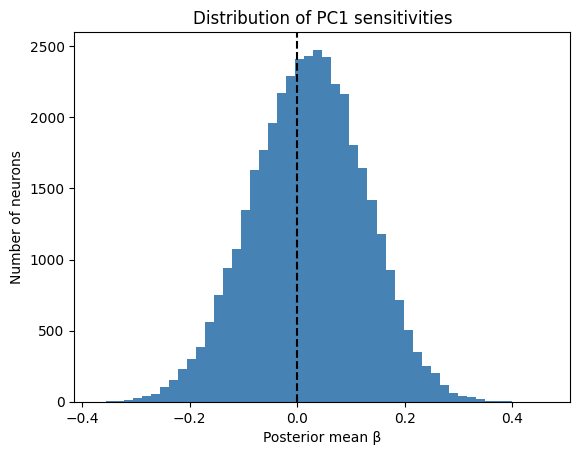

In [2]:
import matplotlib.pyplot as plt
plt.hist(df["beta_mean"], bins=50, color='steelblue')
plt.axvline(0, color='k', linestyle='--')
plt.xlabel("Posterior mean β")
plt.ylabel("Number of neurons")
plt.title("Distribution of PC1 sensitivities")
plt.show()


In [3]:
#!/usr/bin/env python3
import os, pickle
import numpy as np
import pandas as pd
from scipy.special import softmax
from skbio.stats.composition import clr
from sklearn.decomposition import PCA

# -------------------------
# Config
# -------------------------
VIT_PATH   = '/home/maria/Documents/HuggingMouseData/MouseViTEmbeddings/google_vit-base-patch16-224_embeddings_logits.pkl'
NEURAL_PATH= '/home/maria/LuckyMouse/pixel_transformer_neuro/data/processed/hybrid_neural_responses.npy'
N_IMAGES   = 118
REPEATS    = 50
TAU_RHO    = 0.10   # practical-effect threshold on |rho|
GRID_POINTS= 2001   # resolution over rho in [-0.999, 0.999]
BATCH      = 1000   # neurons per batch to cap memory

# -------------------------
# Load neural data and average repeats
# -------------------------
dat = np.load(NEURAL_PATH)  # (n_neurons, 5900)
n_neurons, n_trials = dat.shape
assert n_trials == N_IMAGES * REPEATS, f"Expected {N_IMAGES*REPEATS}, got {n_trials}"
dat = dat.reshape(n_neurons, N_IMAGES, REPEATS)
firing_mean = dat.mean(axis=2)  # (n_neurons, 118)

# -------------------------
# Load ViT embeddings and compute PC1 (>=90% variance)
# -------------------------
with open(VIT_PATH, 'rb') as f:
    vit_arr = pickle.load(f)['natural_scenes']  # (118, 1000)
emb = np.asarray(vit_arr)
assert emb.shape[0] == N_IMAGES

X = softmax(emb, axis=1)
X_clr = clr(X + 1e-12)

pca_full = PCA().fit(X_clr)
cumvar = np.cumsum(pca_full.explained_variance_ratio_)
K = int(np.searchsorted(cumvar, 0.90) + 1)

pca = PCA(n_components=K, random_state=0)
U = pca.fit_transform(X_clr)      # (118, K)
pc1 = U[:, 0]                      # (118,)

# Standardize predictor for numerical stability (not required for correlation itself)
x = (pc1 - pc1.mean()) / (pc1.std(ddof=1) + 1e-12)

# -------------------------
# Helpers: Bayesian correlation via Fisher-z grid
# -------------------------
def bayes_corr_grid(r_obs, n, tau=0.10, grid_points=2001):
    """
    Bayesian posterior over rho using Fisher-z Normal approximation.
    Prior: rho ~ Uniform(-1, 1) (proper).
    Returns: post_mean_rho, lo95, hi95, P(rho>0), P(|rho|>tau), BF10 (H1 vs H0).
    """
    # clip r to open interval to avoid infinities
    r = np.clip(r_obs, -0.999, 0.999)
    z_obs = np.arctanh(r)
    var = 1.0 / (n - 3)
    sd  = np.sqrt(var)

    # rho grid and spacing
    rho_grid = np.linspace(-0.999, 0.999, grid_points)
    dr = rho_grid[1] - rho_grid[0]
    z_grid = np.arctanh(rho_grid)

    # Likelihood under Fisher-z approx: z_obs ~ N(z_grid, var)
    # (evaluate as function of rho)
    ll = -0.5 * ((z_obs - z_grid) / sd)**2
    # no need to include normalizing constant; it cancels in ratios
    L = np.exp(ll - ll.max())  # stabilize

    # Prior density p(rho)=1/2 on [-1,1]
    prior = 0.5

    # Evidence p(data|H1) ≈ ∫ L(rho) * prior d rho
    evidence = prior * np.sum(L) * dr

    # Posterior weights over grid (density * d rho ∝ L * prior * dr)
    w = L * prior
    w /= np.sum(w)  # normalize to mass 1 over grid

    # Posterior summaries
    post_mean = np.sum(rho_grid * w)
    cdf = np.cumsum(w)
    def q(prob):
        return np.interp(prob, cdf, rho_grid)
    lo95, hi95 = q(0.025), q(0.975)

    p_pos = 1.0 - np.interp(0.0, rho_grid, np.cumsum(w))  # P(rho>0)
    p_abs = np.sum(w[(np.abs(rho_grid) > tau)])

    # Bayes factor BF10 via Savage–Dickey:
    # BF01 = posterior density at 0 / prior density at 0
    # BF10 = prior density at 0 / posterior density at 0
    # posterior density at 0 ≈ (L(0)*prior)/evidence
    # so BF10 = evidence / L(0)
    # (constants cancel because we used the same unnormalized Gaussian in both)
    # Evaluate L at rho=0:
    L0 = np.exp(-0.5 * (z_obs / sd)**2)  # since z_grid(0) = 0
    BF10 = evidence / (L0 * dr)  # multiply by dr to match evidence units

    return float(post_mean), float(lo95), float(hi95), float(p_pos), float(p_abs), float(BF10)

# -------------------------
# Run per neuron in batches
# -------------------------
rows = []
n = N_IMAGES
for start in range(0, n_neurons, BATCH):
    end = min(start + BATCH, n_neurons)
    y_block = firing_mean[start:end]  # (batch, 118)

    # Pearson r for each neuron (for reference)
    # (since x is standardized, simple corr is fine)
    x_centered = x - x.mean()  # ~0 already
    y_centered = y_block - y_block.mean(axis=1, keepdims=True)
    r_obs = (y_centered @ x_centered) / (
        np.sqrt(np.sum(y_centered**2, axis=1)) * np.sqrt(np.sum(x_centered**2))
    )
    r_obs = np.clip(r_obs, -0.999, 0.999)

    for j_local, rj in enumerate(r_obs):
        j = start + j_local
        if not np.isfinite(rj):
            rows.append((j, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan))
            continue
        pm, lo, hi, ppos, pabs, bf10 = bayes_corr_grid(
            rj, n=n, tau=TAU_RHO, grid_points=GRID_POINTS
        )
        rows.append((j, float(rj), pm, lo, hi, ppos, pabs, bf10))

# -------------------------
# Save results
# -------------------------
df = pd.DataFrame(rows, columns=[
    "neuron_idx",
    "r_obs",
    "post_mean_rho",
    "rho_lo95",
    "rho_hi95",
    "post_P_rho_gt0",
    f"post_P_abs_rho_gt_{TAU_RHO}",
    "BF10"
])
df.to_csv("bayes_corr_pc1.csv", index=False)
print("✅ Saved bayes_corr_pc1.csv")
print(df.head())

# Quick tallies (examples):
print("Neurons with P(rho>0) >= 0.95:", (df["post_P_rho_gt0"] >= 0.95).sum())
print(f"Neurons with P(|rho| > {TAU_RHO}) >= 0.95:", (df[f'post_P_abs_rho_gt_{TAU_RHO}'] >= 0.95).sum())
print("Neurons with substantial evidence BF10 ≥ 3:", (df["BF10"] >= 3).sum())
print("Neurons with strong evidence BF10 ≥ 10:", (df["BF10"] >= 10).sum())


✅ Saved bayes_corr_pc1.csv
   neuron_idx     r_obs  post_mean_rho  rho_lo95  rho_hi95  post_P_rho_gt0  \
0           0  0.013737       0.013391 -0.166652  0.191796        0.555933   
1           1  0.160575       0.156624 -0.022475  0.327447        0.956998   
2           2  0.175615       0.171316 -0.007261  0.340973        0.970045   
3           3 -0.000108      -0.000106 -0.179858  0.178654        0.497385   
4           4 -0.012887      -0.012562 -0.191991  0.166467        0.443371   

   post_P_abs_rho_gt_0.1        BF10  
0               0.280992  117.233535  
1               0.739004  511.127100  
2               0.788826  687.899003  
3               0.275886  115.989263  
4               0.280381  117.083235  
Neurons with P(rho>0) >= 0.95: 3999
Neurons with P(|rho| > 0.1) >= 0.95: 620
Neurons with substantial evidence BF10 ≥ 3: 39209
Neurons with strong evidence BF10 ≥ 10: 39209
